<a href="https://colab.research.google.com/github/UncleSamTech/AndroidIdRecreateApp/blob/master/Samuel_Iwuchukwu_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.7.0 >& /dev/null

In [2]:
!pip install tensorflow-quantum==0.7.2 >& /dev/null

In [3]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py'>

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [5]:
a, b = sympy.symbols('a b')

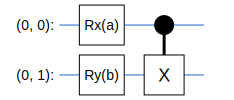

In [6]:
# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1))

SVGCircuit(circuit)

In [7]:
# Calculate a state vector with a=0.5 and b=-0.5.
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state_vector
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

In [8]:
z0 = cirq.Z(q0)

qubit_map={q0: 0, q1: 1}

z0.expectation_from_state_vector(output_state_vector, qubit_map).real

0.8775825500488281

In [9]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_state_vector(output_state_vector, qubit_map).real

-0.04063427448272705

In [10]:
# Rank 1 tensor containing 1 circuit.
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [11]:
# Rank 1 tensor containing 2 Pauli operators.
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape

TensorShape([2])

In [13]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=np.float32)

In [14]:
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state_vector = cirq_simulator.simulate(circuit, resolver).final_state_vector
    cirq_results.append(
        [z0.expectation_from_state_vector(final_state_vector, {
            q0: 0,
            q1: 1
        }).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[ 0.6840536 ]
 [-0.62834775]
 [ 0.37950867]
 [-0.99609953]
 [-0.90840441]]


In [15]:
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.684055  ],
       [-0.62834847],
       [ 0.37951034],
       [-0.99609977],
       [-0.9084039 ]], dtype=float32)>

**The Controlled Circuit Definition**

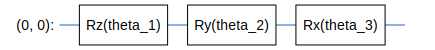

In [16]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

In [17]:
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [18]:
controller(tf.constant([[0.0],[1.0]])).numpy()

array([[ 0.        ,  0.        ,  0.        ],
       [-0.461811  ,  0.34468922,  0.8085664 ]], dtype=float32)

In [19]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

In [20]:
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

In [21]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

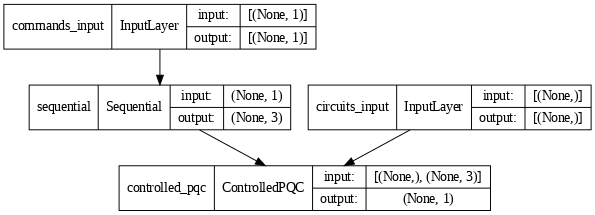

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [23]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [24]:
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit

In [25]:
datapoint_circuits.shape

TensorShape([2])

In [26]:
model([datapoint_circuits, commands]).numpy()

array([[-0.00270444],
       [ 0.74734396]], dtype=float32)

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

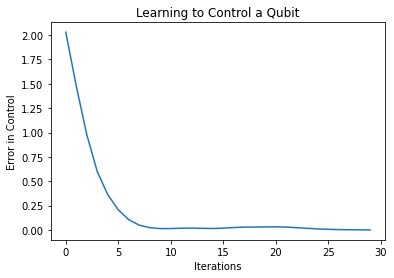

In [28]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [29]:
def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state_vector
    expt = cirq.Z(qubit).expectation_from_state_vector(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expt}\n')


check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [0.36442152 1.6028341  0.11228433]
Which gives an actual expectation of: 0.9882626533508301

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-0.13278931 -1.917663   -0.7645972 ]
Which gives an actual expectation of: -0.9681740403175354



In [30]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.9882621 ],
       [-0.96817374]], dtype=float32)>

# Exercise 1

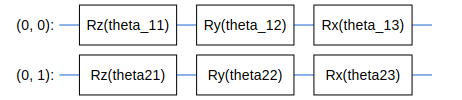

In [32]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_11 theta_12 theta_13 theta21 theta22 theta23')

# Create the parameterized circuit.
q0, q1 = cirq.GridQubit.rect(1, 2)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(q0),
    cirq.ry(control_params[1])(q0),
    cirq.rx(control_params[2])(q0),
    cirq.rz(control_params[3])(q1),
    cirq.ry(control_params[4])(q1),
    cirq.rx(control_params[5])(q1))
SVGCircuit(model_circuit)

In [33]:
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(6)
])

In [34]:
controller(tf.constant([[0.0],[1.0]])).numpy()

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [-8.0875590e-02, -3.2638758e-04, -4.1039109e-01,  3.2331020e-01,
        -8.2704961e-02,  5.9821159e-01]], dtype=float32)

In [35]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

In [36]:
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

In [37]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

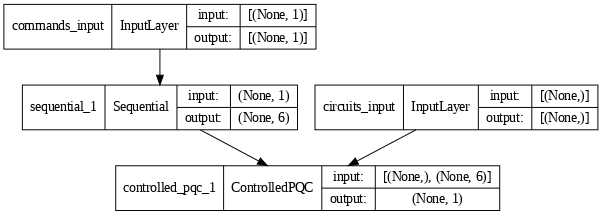

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [39]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

In [40]:
# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [41]:
random_rotations = np.random.uniform(0, 2 * np.pi, 6)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit),
  cirq.rx(random_rotations[3])(qubit),
  cirq.ry(random_rotations[4])(qubit),
  cirq.rz(random_rotations[5])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit

In [42]:
datapoint_circuits.shape

TensorShape([2])

In [43]:
model([datapoint_circuits, commands]).numpy()

array([[-0.21493948],
       [-0.72691154]], dtype=float32)

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

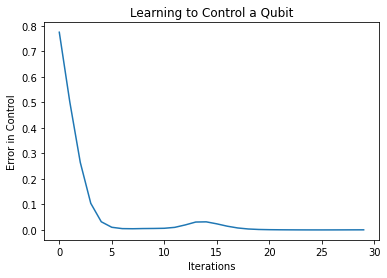

In [45]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [46]:
check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [ 0.04131287 -0.1330227   1.029002    0.89670515  0.9480263  -2.0279005 ]
Which gives an actual expectation of: -0.867507815361023

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-0.56129557 -0.8368194  -0.09697608  0.59703946  0.13471341  1.0999753 ]
Which gives an actual expectation of: -0.7546619772911072



In [47]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.99789196],
       [-0.96841013]], dtype=float32)>

# Build a QCNN

In [48]:
qubit = cirq.GridQubit(0, 0)

# Define some circuits.
circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))

# Convert to a tensor.
input_circuit_tensor = tfq.convert_to_tensor([circuit1, circuit2])

# Define a circuit that we want to append
y_circuit = cirq.Circuit(cirq.Y(qubit))

# Instantiate our layer
y_appender = tfq.layers.AddCircuit()

# Run our circuit tensor through the layer and save the output.
output_circuit_tensor = y_appender(input_circuit_tensor, append=y_circuit)

In [49]:
print(tfq.from_tensor(input_circuit_tensor))

[cirq.Circuit([
     cirq.Moment(
         cirq.X(cirq.GridQubit(0, 0)),
     ),
 ])
 cirq.Circuit([
     cirq.Moment(
         cirq.H(cirq.GridQubit(0, 0)),
     ),
 ])                                   ]


In [50]:
print(tfq.from_tensor(output_circuit_tensor))

[cirq.Circuit([
     cirq.Moment(
         cirq.X(cirq.GridQubit(0, 0)),
     ),
     cirq.Moment(
         cirq.Y(cirq.GridQubit(0, 0)),
     ),
 ])
 cirq.Circuit([
     cirq.Moment(
         cirq.H(cirq.GridQubit(0, 0)),
     ),
     cirq.Moment(
         cirq.Y(cirq.GridQubit(0, 0)),
     ),
 ])                                   ]


# Quantum Convolutional Neural Network

In [53]:
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)
            #print('excitations : ' , excitations, 'labels : ' , labels)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [54]:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───X^0.621─── Output: -1
Input: (0, 1): ───X^-0.947─── Output: -1


In [55]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

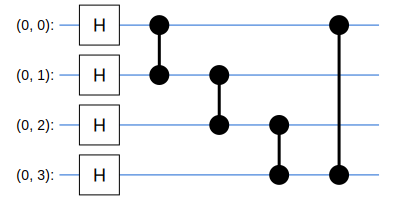

In [52]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

In [57]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

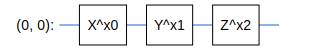

In [58]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

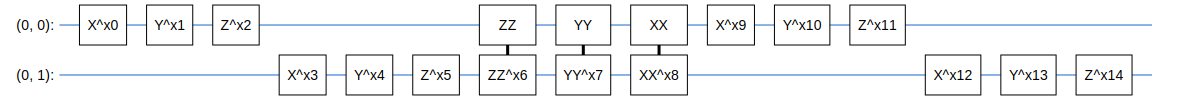

In [59]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

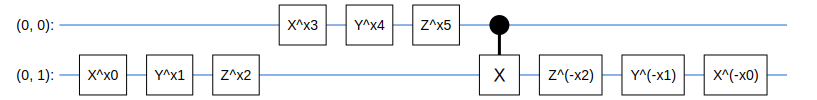

In [60]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

In [61]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

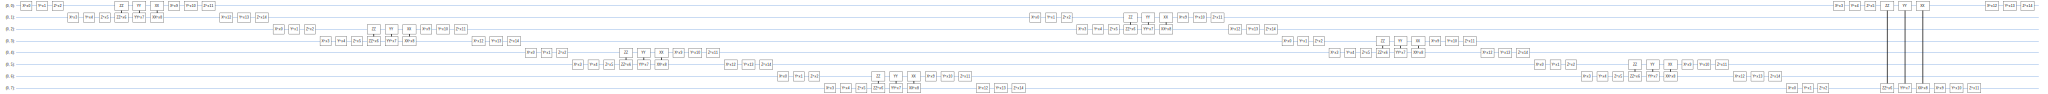

In [62]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

In [63]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

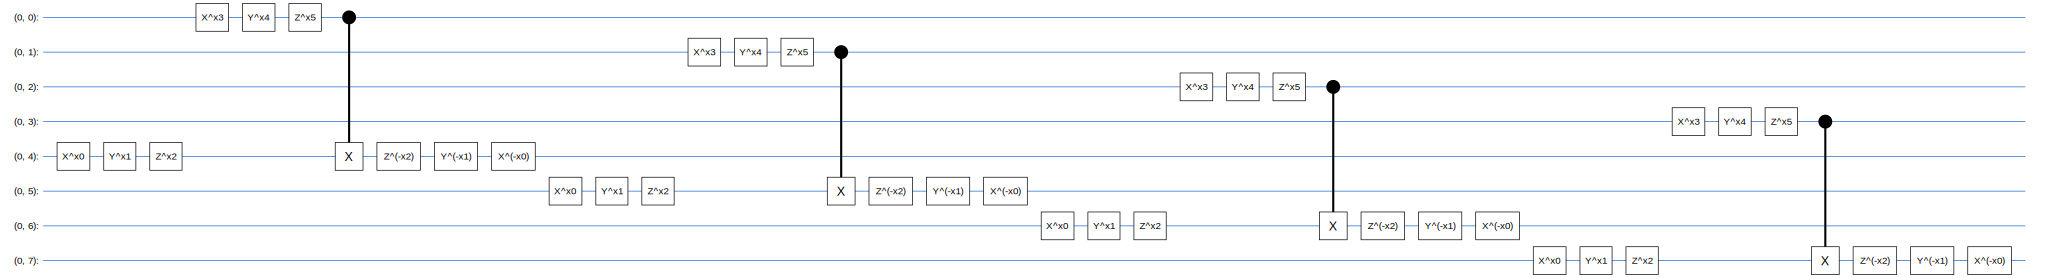

In [64]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

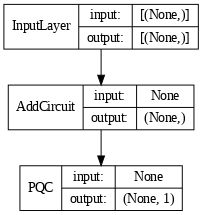

In [65]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]],
                                          symbols[57:63])
    return model_circuit


# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [66]:
# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)


# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Epoch 1/25
7/7 [==============================] - 2s 245ms/step - loss: 0.8730 - custom_accuracy: 0.7054 - val_loss: 0.8251 - val_custom_accuracy: 0.6667
Epoch 2/25
7/7 [==============================] - 1s 207ms/step - loss: 0.7420 - custom_accuracy: 0.7500 - val_loss: 0.7676 - val_custom_accuracy: 0.7292
Epoch 3/25
7/7 [==============================] - 1s 202ms/step - loss: 0.6661 - custom_accuracy: 0.8214 - val_loss: 0.6476 - val_custom_accuracy: 0.8542
Epoch 4/25
7/7 [==============================] - 1s 202ms/step - loss: 0.5933 - custom_accuracy: 0.8839 - val_loss: 0.6252 - val_custom_accuracy: 0.7917
Epoch 5/25
7/7 [==============================] - 2s 276ms/step - loss: 0.5526 - custom_accuracy: 0.8661 - val_loss: 0.5763 - val_custom_accuracy: 0.8542
Epoch 6/25
7/7 [==============================] - 2s 310ms/step - loss: 0.5066 - custom_accuracy: 0.9286 - val_loss: 0.5509 - val_custom_accuracy: 0.9167
Epoch 7/25
7/7 [==============================] - 2s 303ms/step - loss: 0.48

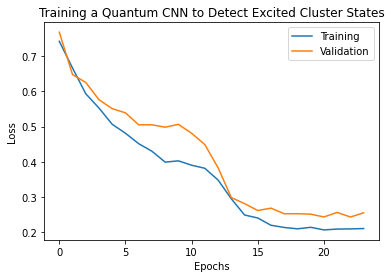

In [67]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise 2

In [69]:
def generate_data1(qubits):
    """Generate training and testing data."""
    n_rounds = 50  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [70]:
# Generate some training data.
cluster_state_bits = cirq.GridQubit.rect(1, 12)
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)

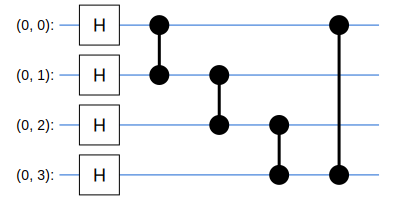

In [71]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

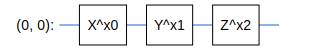

In [72]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

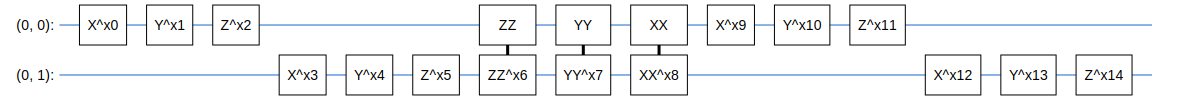

In [73]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

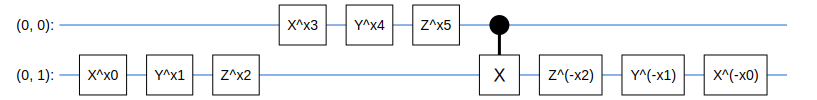

In [74]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

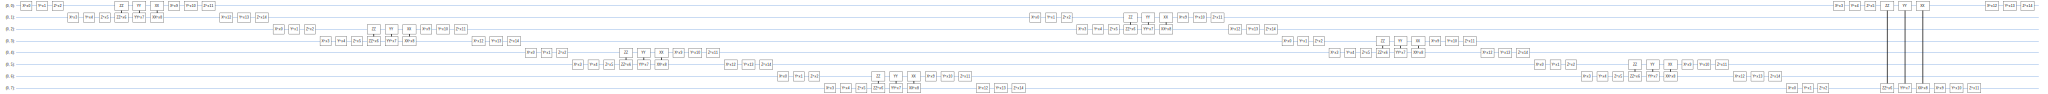

In [75]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

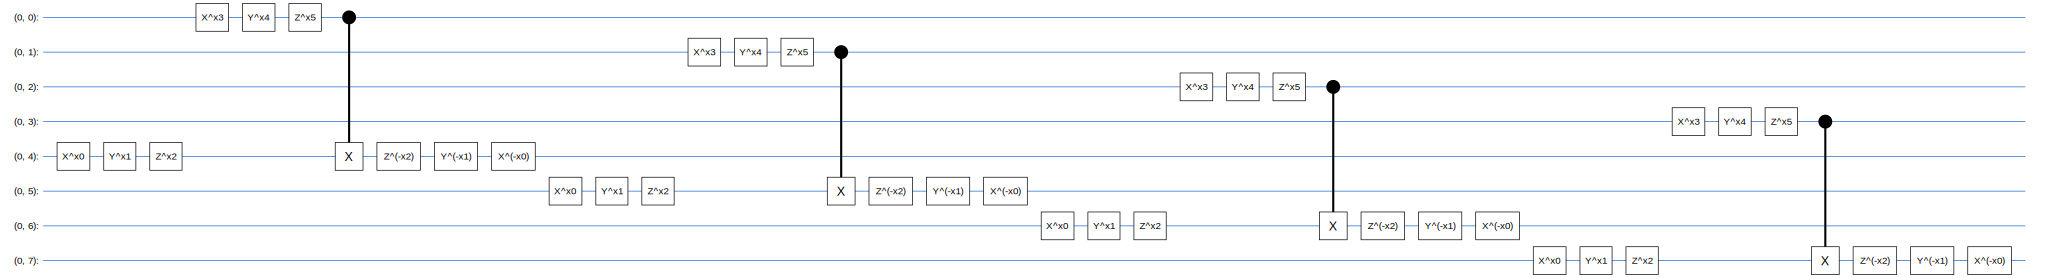

In [76]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

In [77]:
# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

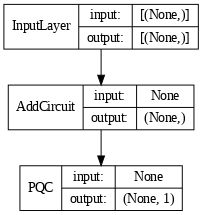

In [78]:
# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

# Hybrid models

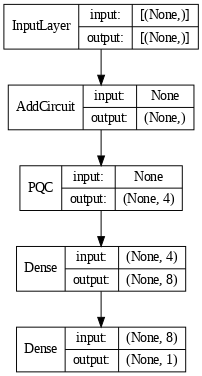

In [79]:
# 1-local operators to read out
readouts = [cirq.Z(bit) for bit in cluster_state_bits[4:]]


def multi_readout_model_circuit(qubits):
    """Make a model circuit with less quantum pool and conv operations."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    return model_circuit


# Build a model enacting the logic in 2.1 of this notebook.
excitation_input_dual = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_dual = tfq.layers.AddCircuit()(
    excitation_input_dual, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model_dual = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_dual)

d1_dual = tf.keras.layers.Dense(8)(quantum_model_dual)

d2_dual = tf.keras.layers.Dense(1)(d1_dual)

hybrid_model = tf.keras.Model(inputs=[excitation_input_dual], outputs=[d2_dual])

# Display the model architecture
tf.keras.utils.plot_model(hybrid_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [80]:
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     loss=tf.losses.mse,
                     metrics=[custom_accuracy])

hybrid_history = hybrid_model.fit(x=train_excitations,
                                  y=train_labels,
                                  batch_size=16,
                                  epochs=25,
                                  verbose=1,
                                  validation_data=(test_excitations,
                                                   test_labels))

Epoch 1/25
11/11 [==============================] - 2s 138ms/step - loss: 0.9008 - custom_accuracy: 0.6875 - val_loss: 0.7937 - val_custom_accuracy: 0.7875
Epoch 2/25
11/11 [==============================] - 1s 110ms/step - loss: 0.7566 - custom_accuracy: 0.7841 - val_loss: 0.7023 - val_custom_accuracy: 0.7375
Epoch 3/25
11/11 [==============================] - 1s 113ms/step - loss: 0.5850 - custom_accuracy: 0.8068 - val_loss: 0.6639 - val_custom_accuracy: 0.8250
Epoch 4/25
11/11 [==============================] - 1s 118ms/step - loss: 0.5930 - custom_accuracy: 0.8409 - val_loss: 0.6705 - val_custom_accuracy: 0.8125
Epoch 5/25
11/11 [==============================] - 2s 173ms/step - loss: 0.6050 - custom_accuracy: 0.8182 - val_loss: 0.6688 - val_custom_accuracy: 0.8250
Epoch 6/25
11/11 [==============================] - 2s 176ms/step - loss: 0.5868 - custom_accuracy: 0.8239 - val_loss: 0.6556 - val_custom_accuracy: 0.8125
Epoch 7/25
11/11 [==============================] - 2s 173ms/ste

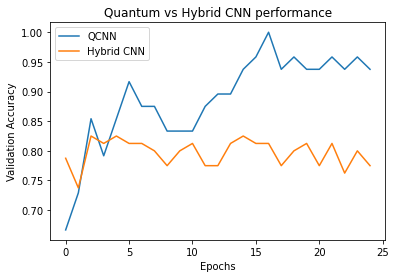

In [81]:
plt.plot(history.history['val_custom_accuracy'], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

In [82]:
# 1-local operators to read out
readouts = [cirq.Z(bit) for bit in cluster_state_bits[4:]]


def multi_readout_model_circuit(qubits):
    """Make a model circuit with less quantum pool and conv operations."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    return model_circuit

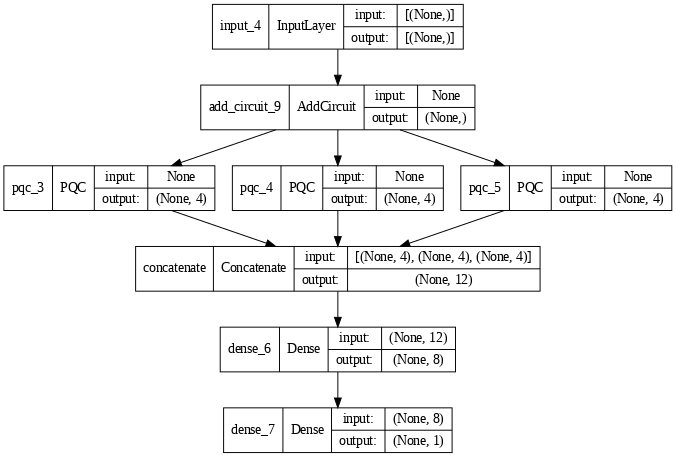

In [83]:
excitation_input_multi = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_multi = tfq.layers.AddCircuit()(
    excitation_input_multi, prepend=cluster_state_circuit(cluster_state_bits))

# apply 3 different filters and measure expectation values

quantum_model_multi1 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi2 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi3 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

# concatenate outputs and feed into a small classical NN
concat_out = tf.keras.layers.concatenate(
    [quantum_model_multi1, quantum_model_multi2, quantum_model_multi3])

dense_1 = tf.keras.layers.Dense(8)(concat_out)

dense_2 = tf.keras.layers.Dense(1)(dense_1)

multi_qconv_model = tf.keras.Model(inputs=[excitation_input_multi],
                                   outputs=[dense_2])

# Display the model architecture
tf.keras.utils.plot_model(multi_qconv_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

In [85]:
multi_qconv_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
    loss=tf.losses.mse,
    metrics=[custom_accuracy])

multi_qconv_history = multi_qconv_model.fit(x=train_excitations,
                                            y=train_labels,
                                            batch_size=16,
                                            epochs=25,
                                            verbose=1,
                                            validation_data=(test_excitations,
                                                             test_labels))

Epoch 1/25
11/11 [==============================] - 4s 317ms/step - loss: 0.7264 - custom_accuracy: 0.7898 - val_loss: 0.6891 - val_custom_accuracy: 0.7250
Epoch 2/25
11/11 [==============================] - 3s 290ms/step - loss: 0.5745 - custom_accuracy: 0.8466 - val_loss: 0.6747 - val_custom_accuracy: 0.7500
Epoch 3/25
11/11 [==============================] - 4s 335ms/step - loss: 0.5770 - custom_accuracy: 0.8125 - val_loss: 0.7481 - val_custom_accuracy: 0.8125
Epoch 4/25
11/11 [==============================] - 5s 465ms/step - loss: 0.6161 - custom_accuracy: 0.8125 - val_loss: 0.6695 - val_custom_accuracy: 0.7625
Epoch 5/25
11/11 [==============================] - 3s 300ms/step - loss: 0.5982 - custom_accuracy: 0.8239 - val_loss: 0.7358 - val_custom_accuracy: 0.6875
Epoch 6/25
11/11 [==============================] - 3s 291ms/step - loss: 0.6202 - custom_accuracy: 0.8239 - val_loss: 0.6975 - val_custom_accuracy: 0.7500
Epoch 7/25
11/11 [==============================] - 3s 286ms/ste

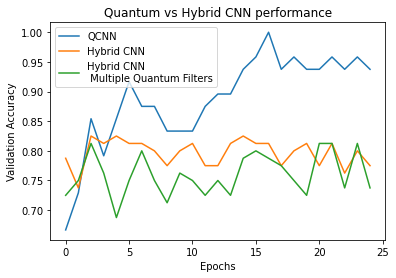

In [86]:
plt.plot(history.history['val_custom_accuracy'][:25], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'][:25], label='Hybrid CNN')
plt.plot(multi_qconv_history.history['val_custom_accuracy'][:25],
         label='Hybrid CNN \n Multiple Quantum Filters')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

**Exercise 4**

In [87]:
!pip install pennylane>& /dev/null

In [88]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [89]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [90]:
# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [91]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))
    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def quanv(image):

     out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
     for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):out[j // 2, k // 2, c] = q_results[c]
     return out
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    if (os.path.exists(SAVE_PATH))==False:
      os.makedirs(SAVE_PATH)
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

Quantum pre-processing of train images:

Quantum pre-processing of test images:


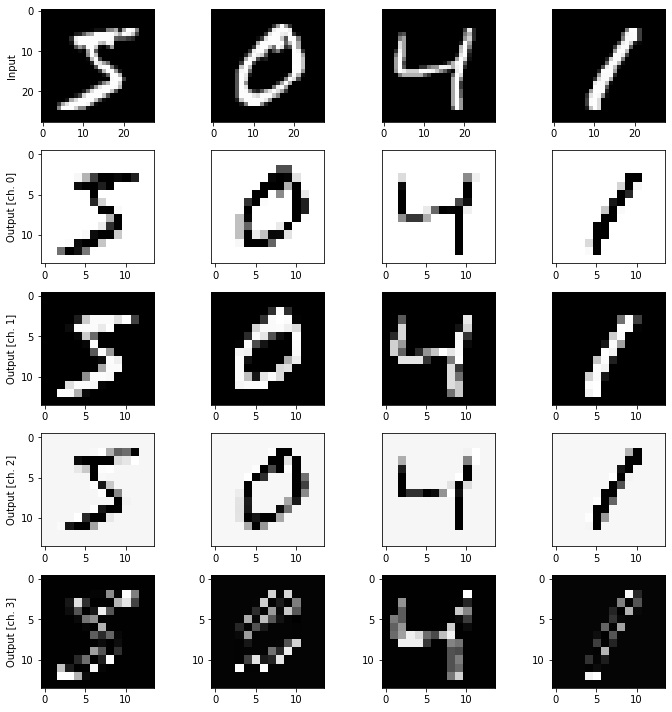

In [92]:
# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")
n_samples = 4
n_channels = 4
def plotter():
  fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
  for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

  plt.tight_layout()
  plt.show()
plotter()

In [93]:
def Model1():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Conv2D(32,(3,3),activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(12),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [94]:
def Model2():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [95]:
q_model1 = Model1()

q_history1 = q_model1.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.5552 - accuracy: 0.1400 - val_loss: 2.1421 - val_accuracy: 0.2000 - 1s/epoch - 114ms/step
Epoch 2/30
13/13 - 0s - loss: 1.6773 - accuracy: 0.5600 - val_loss: 1.7655 - val_accuracy: 0.5000 - 95ms/epoch - 7ms/step
Epoch 3/30
13/13 - 0s - loss: 0.9637 - accuracy: 0.8600 - val_loss: 1.5336 - val_accuracy: 0.4333 - 134ms/epoch - 10ms/step
Epoch 4/30
13/13 - 0s - loss: 0.5190 - accuracy: 0.9800 - val_loss: 1.2194 - val_accuracy: 0.5667 - 123ms/epoch - 9ms/step
Epoch 5/30
13/13 - 0s - loss: 0.2898 - accuracy: 1.0000 - val_loss: 1.0807 - val_accuracy: 0.7000 - 112ms/epoch - 9ms/step
Epoch 6/30
13/13 - 0s - loss: 0.1619 - accuracy: 1.0000 - val_loss: 0.9805 - val_accuracy: 0.7333 - 149ms/epoch - 11ms/step
Epoch 7/30
13/13 - 0s - loss: 0.0848 - accuracy: 1.0000 - val_loss: 0.9878 - val_accuracy: 0.7000 - 114ms/epoch - 9ms/step
Epoch 8/30
13/13 - 0s - loss: 0.0491 - accuracy: 1.0000 - val_loss: 0.9254 - val_accuracy: 0.7667 - 94ms/epoch - 7ms/step
Epoch 9/30
13/13 

In [96]:
c_model1 = Model1()

c_history1 = c_model1.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - loss: 2.3323 - accuracy: 0.1600 - val_loss: 1.8659 - val_accuracy: 0.3667 - 2s/epoch - 134ms/step
Epoch 2/30
13/13 - 0s - loss: 1.3822 - accuracy: 0.6600 - val_loss: 1.6368 - val_accuracy: 0.3333 - 112ms/epoch - 9ms/step
Epoch 3/30
13/13 - 0s - loss: 0.7554 - accuracy: 0.8600 - val_loss: 1.3760 - val_accuracy: 0.5667 - 306ms/epoch - 24ms/step
Epoch 4/30
13/13 - 0s - loss: 0.3390 - accuracy: 0.9800 - val_loss: 1.1911 - val_accuracy: 0.6000 - 238ms/epoch - 18ms/step
Epoch 5/30
13/13 - 0s - loss: 0.2027 - accuracy: 0.9800 - val_loss: 1.1401 - val_accuracy: 0.6000 - 233ms/epoch - 18ms/step
Epoch 6/30
13/13 - 0s - loss: 0.1059 - accuracy: 1.0000 - val_loss: 1.2587 - val_accuracy: 0.6333 - 100ms/epoch - 8ms/step
Epoch 7/30
13/13 - 0s - loss: 0.0569 - accuracy: 1.0000 - val_loss: 1.1357 - val_accuracy: 0.5667 - 121ms/epoch - 9ms/step
Epoch 8/30
13/13 - 0s - loss: 0.0228 - accuracy: 1.0000 - val_loss: 1.0616 - val_accuracy: 0.6333 - 109ms/epoch - 8ms/step
Epoch 9/30
13/

In [97]:
q_model2 = Model2()

q_history2 = q_model2.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/30
13/13 - 1s - loss: 2.6931 - accuracy: 0.1400 - val_loss: 2.3518 - val_accuracy: 0.2333 - 509ms/epoch - 39ms/step
Epoch 2/30
13/13 - 0s - loss: 1.9462 - accuracy: 0.2800 - val_loss: 2.1772 - val_accuracy: 0.2667 - 65ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 1.5823 - accuracy: 0.5400 - val_loss: 2.0828 - val_accuracy: 0.4333 - 55ms/epoch - 4ms/step
Epoch 4/30
13/13 - 0s - loss: 1.2500 - accuracy: 0.6000 - val_loss: 1.7684 - val_accuracy: 0.4667 - 62ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.0561 - accuracy: 0.8400 - val_loss: 1.6740 - val_accuracy: 0.4667 - 72ms/epoch - 6ms/step
Epoch 6/30
13/13 - 0s - loss: 0.8751 - accuracy: 0.8400 - val_loss: 1.6668 - val_accuracy: 0.4667 - 63ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.6993 - accuracy: 0.9000 - val_loss: 1.5271 - val_accuracy: 0.5000 - 65ms/epoch - 5ms/step
Epoch 8/30
13/13 - 0s - loss: 0.5787 - accuracy: 1.0000 - val_loss: 1.4191 - val_accuracy: 0.6000 - 59ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

In [98]:
c_model2 = Model2()

c_history2 = c_model2.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.4150 - accuracy: 0.0600 - val_loss: 2.2431 - val_accuracy: 0.1667 - 383ms/epoch - 29ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0335 - accuracy: 0.3000 - val_loss: 2.1039 - val_accuracy: 0.2667 - 41ms/epoch - 3ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7260 - accuracy: 0.5600 - val_loss: 1.9831 - val_accuracy: 0.3333 - 41ms/epoch - 3ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4866 - accuracy: 0.7200 - val_loss: 1.8568 - val_accuracy: 0.5000 - 54ms/epoch - 4ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2821 - accuracy: 0.8200 - val_loss: 1.7372 - val_accuracy: 0.5333 - 45ms/epoch - 3ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1158 - accuracy: 0.9000 - val_loss: 1.6398 - val_accuracy: 0.6333 - 46ms/epoch - 4ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9696 - accuracy: 0.9200 - val_loss: 1.5669 - val_accuracy: 0.6667 - 40ms/epoch - 3ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8491 - accuracy: 0.9600 - val_loss: 1.4942 - val_accuracy: 0.6667 - 40ms/epoch - 3ms/step
Epoch 9/30
13/13 - 0s 

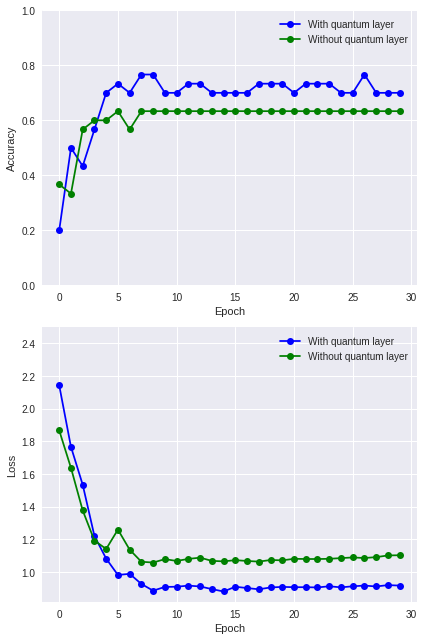

In [99]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history1.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history1.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history1.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history1.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

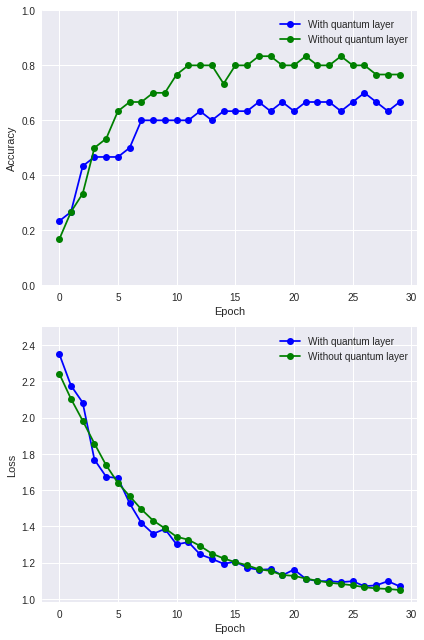

In [100]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history2.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history2.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history2.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history2.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

# Exercise 4

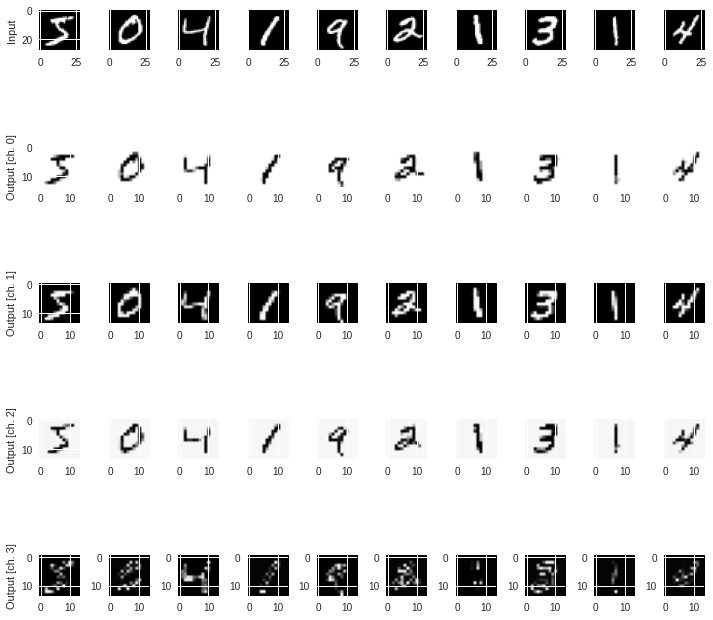

In [101]:
# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")
n_samples = 10
n_channels = 4
def plotter():
  fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
  for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

  plt.tight_layout()
  plt.show()
plotter()

In [102]:
q_model1 = Model1()

q_history1 = q_model1.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.4927 - accuracy: 0.2000 - val_loss: 2.0467 - val_accuracy: 0.3333 - 925ms/epoch - 71ms/step
Epoch 2/30
13/13 - 0s - loss: 1.5832 - accuracy: 0.6800 - val_loss: 1.8259 - val_accuracy: 0.4333 - 90ms/epoch - 7ms/step
Epoch 3/30
13/13 - 0s - loss: 0.9421 - accuracy: 0.8800 - val_loss: 1.5539 - val_accuracy: 0.5000 - 142ms/epoch - 11ms/step
Epoch 4/30
13/13 - 0s - loss: 0.5164 - accuracy: 0.9000 - val_loss: 1.4009 - val_accuracy: 0.6000 - 77ms/epoch - 6ms/step
Epoch 5/30
13/13 - 0s - loss: 0.3035 - accuracy: 0.9800 - val_loss: 1.2866 - val_accuracy: 0.5667 - 131ms/epoch - 10ms/step
Epoch 6/30
13/13 - 0s - loss: 0.1725 - accuracy: 1.0000 - val_loss: 1.2173 - val_accuracy: 0.6333 - 145ms/epoch - 11ms/step
Epoch 7/30
13/13 - 0s - loss: 0.0911 - accuracy: 1.0000 - val_loss: 1.2185 - val_accuracy: 0.6333 - 145ms/epoch - 11ms/step
Epoch 8/30
13/13 - 0s - loss: 0.0554 - accuracy: 1.0000 - val_loss: 1.1503 - val_accuracy: 0.6000 - 94ms/epoch - 7ms/step
Epoch 9/30
13/

In [103]:
c_model1 = Model1()

c_history1 = c_model1.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.3736 - accuracy: 0.2000 - val_loss: 1.9526 - val_accuracy: 0.5333 - 503ms/epoch - 39ms/step
Epoch 2/30
13/13 - 0s - loss: 1.3417 - accuracy: 0.8600 - val_loss: 1.5648 - val_accuracy: 0.6333 - 91ms/epoch - 7ms/step
Epoch 3/30
13/13 - 0s - loss: 0.6274 - accuracy: 0.9000 - val_loss: 1.2821 - val_accuracy: 0.5333 - 98ms/epoch - 8ms/step
Epoch 4/30
13/13 - 0s - loss: 0.2236 - accuracy: 1.0000 - val_loss: 1.0787 - val_accuracy: 0.6667 - 73ms/epoch - 6ms/step
Epoch 5/30
13/13 - 0s - loss: 0.1021 - accuracy: 1.0000 - val_loss: 1.1061 - val_accuracy: 0.6000 - 91ms/epoch - 7ms/step
Epoch 6/30
13/13 - 0s - loss: 0.0484 - accuracy: 1.0000 - val_loss: 0.9769 - val_accuracy: 0.7333 - 82ms/epoch - 6ms/step
Epoch 7/30
13/13 - 0s - loss: 0.0229 - accuracy: 1.0000 - val_loss: 1.0323 - val_accuracy: 0.6667 - 71ms/epoch - 5ms/step
Epoch 8/30
13/13 - 0s - loss: 0.0155 - accuracy: 1.0000 - val_loss: 1.0870 - val_accuracy: 0.6333 - 82ms/epoch - 6ms/step
Epoch 9/30
13/13 - 0s 

In [104]:
q_model2 = Model2()

q_history2 = q_model2.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.9963 - accuracy: 0.0800 - val_loss: 2.5021 - val_accuracy: 0.0667 - 712ms/epoch - 55ms/step
Epoch 2/30
13/13 - 0s - loss: 2.2040 - accuracy: 0.2000 - val_loss: 2.1765 - val_accuracy: 0.1667 - 72ms/epoch - 6ms/step
Epoch 3/30
13/13 - 0s - loss: 1.8560 - accuracy: 0.3000 - val_loss: 2.0748 - val_accuracy: 0.1667 - 58ms/epoch - 4ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4564 - accuracy: 0.5800 - val_loss: 1.8035 - val_accuracy: 0.4333 - 68ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2361 - accuracy: 0.7600 - val_loss: 1.6810 - val_accuracy: 0.5000 - 67ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 1.0321 - accuracy: 0.8600 - val_loss: 1.6934 - val_accuracy: 0.4667 - 65ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.8202 - accuracy: 0.8600 - val_loss: 1.5490 - val_accuracy: 0.5000 - 74ms/epoch - 6ms/step
Epoch 8/30
13/13 - 0s - loss: 0.6859 - accuracy: 0.9400 - val_loss: 1.4516 - val_accuracy: 0.5333 - 64ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

In [105]:
c_model2 = Model2()

c_history2 = c_model2.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.4492 - accuracy: 0.0800 - val_loss: 2.1578 - val_accuracy: 0.2333 - 390ms/epoch - 30ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0367 - accuracy: 0.4200 - val_loss: 2.0203 - val_accuracy: 0.3667 - 54ms/epoch - 4ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7389 - accuracy: 0.5400 - val_loss: 1.8972 - val_accuracy: 0.4667 - 60ms/epoch - 5ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4964 - accuracy: 0.6400 - val_loss: 1.7747 - val_accuracy: 0.5667 - 39ms/epoch - 3ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2867 - accuracy: 0.8000 - val_loss: 1.6664 - val_accuracy: 0.6000 - 52ms/epoch - 4ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1221 - accuracy: 0.8800 - val_loss: 1.5825 - val_accuracy: 0.6333 - 43ms/epoch - 3ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9792 - accuracy: 0.8800 - val_loss: 1.5192 - val_accuracy: 0.6000 - 41ms/epoch - 3ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8580 - accuracy: 0.8800 - val_loss: 1.4526 - val_accuracy: 0.6333 - 41ms/epoch - 3ms/step
Epoch 9/30
13/13 - 0s 

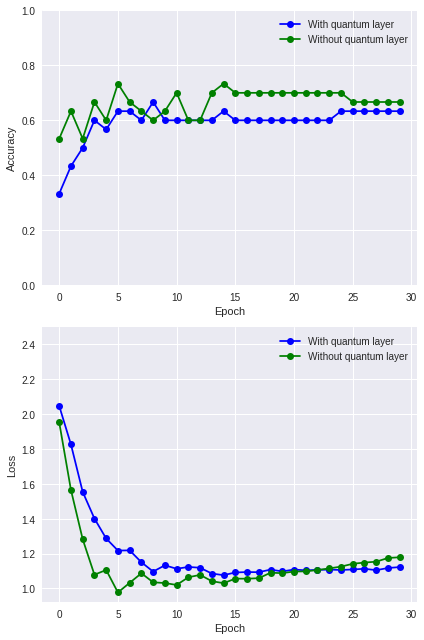

In [106]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history1.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history1.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history1.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history1.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

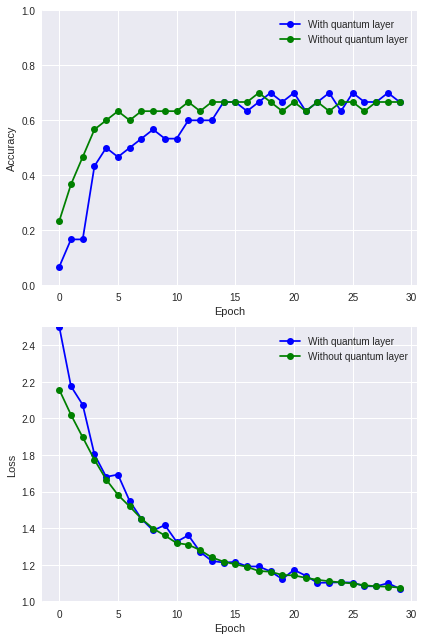

In [107]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history2.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history2.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history2.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history2.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()